[![Binder](https://mybinder.org/badge_logo.svg)](https://nbviewer.org/github/vicente-gonzalez-ruiz/motion_estimation/blob/main/src/motion_estimation/full_search_dense_ME.ipynb)

[![Colab](https://badgen.net/badge/Launch/on%20Google%20Colab/blue?icon=notebook)](https://colab.research.google.com/github/vicente-gonzalez-ruiz/motion_estimation/blob/main/src/motion_estimation/full_search_dense_ME.ipynb)

# Image denoising using OF

Algorithm:

1. denoised_image = 0
2. for i in range(iters):
    1. randomized_noisy_image = randomize(noisy_image)
    2. randomized_and_compensated_noisy_image = project_A_to_B(A=randomized_noisy_image, B=noisy_image)
    3. average_image += (noisy_image + randomized_and_compensated_noisy_image)/2
    4. denoised_image += average_image
3. denoised_image /= iters

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !apt update
    !apt install imagemagick
    !apt install cm-super
    !apt install dvipng
    !apt install bc
    !apt install texlive-latex-extra
    !apt install texlive-fonts-recommended

In [2]:
!which python

In [3]:
!pip install --upgrade pip

In [4]:
try:
    import numpy as np
except:
    !pip install numpy
    import numpy as np

try:
    from scipy import ndimage
except:
    !pip install scipy
    from scipy import ndimage

In [5]:
try:
    import matplotlib
    import matplotlib.pyplot as plt
    import matplotlib.axes as ax
    import pylab
except:
    !pip install matplotlib
    import matplotlib
    import matplotlib.pyplot as plt
    import matplotlib.axes as ax
    import pylab

plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}" #for \text command
   
%matplotlib inline

In [6]:
try:
    from color_transforms import YCoCg as YUV
except:
    !pip install "color_transforms @ git+https://github.com/vicente-gonzalez-ruiz/color_transforms"
    from color_transforms import YCoCg as YUV

In [7]:
try:
    from image_IO import image_1 as gray_image
    from image_IO import image_3 as RGB_image
except:
    !pip install "image_IO @ git+https://github.com/vicente-gonzalez-ruiz/image_IO"
    from image_IO import image_1 as gray_image
    from image_IO import image_3 as RGB_image

In [8]:
try:
    from information_theory import information
    #from information_theory import distortion
except:
    !pip install "information_theory @ git+https://github.com/vicente-gonzalez-ruiz/information_theory"
    from information_theory import information
    #from information_theory import distortion

In [9]:
try:
    import full_search
    import display
    import prediction
except:
    !pip install "motion_estimation @ git+https://github.com/vicente-gonzalez-ruiz/motion_estimation"
    from motion_estimation import optical_flow as motion
    from motion_estimation import display
    from motion_estimation import prediction

extension mode = 1


In [10]:
%%bash
if [ -d "$HOME/repos" ]; then
    echo "\"$HOME/repos\" exists"
else
    mkdir ~/repos
    echo Created $HOME/repos
fi

"/home/vruiz/repos" exists


In [11]:
import numpy as np
import cv2
import random

[image_3.py:87 print_stats() INFO] component=0 max=255 min=54 avg=180.22401428222656
[image_3.py:87 print_stats() INFO] component=1 max=248 min=1 avg=99.05646133422852
[image_3.py:87 print_stats() INFO] component=2 max=239 min=8 avg=105.41263198852539


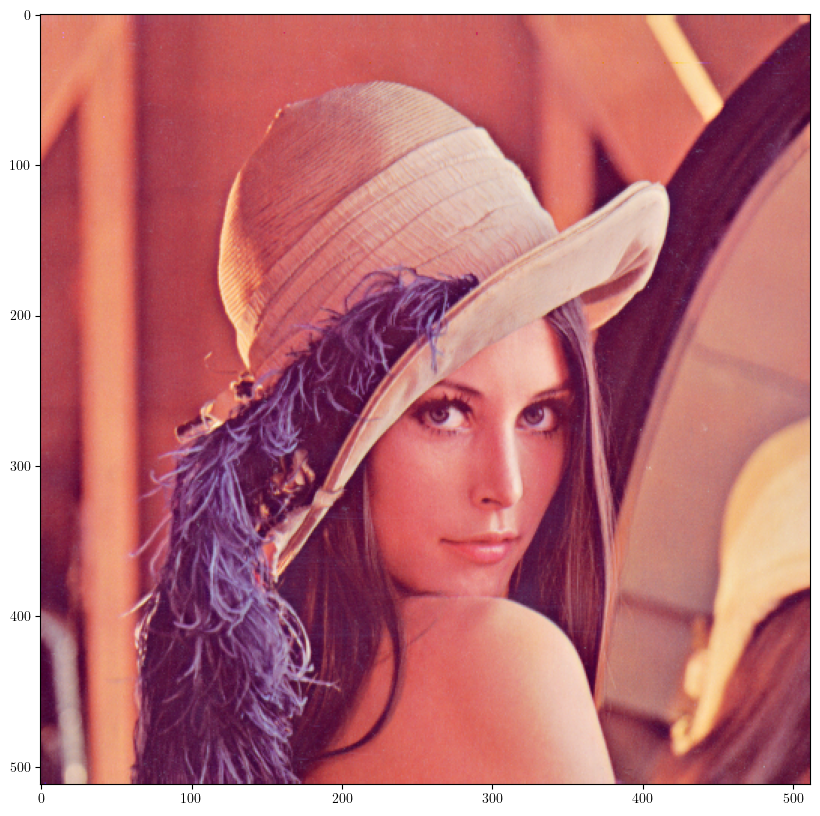

In [12]:
import urllib
from skimage import io as skimage_io

fn = "http://www.hpca.ual.es/~vruiz/images/lena.png"
req = urllib.request.Request(fn, method='HEAD')
f = urllib.request.urlopen(req)
img = skimage_io.imread(fn)
RGB_image.show(img,"")

In [13]:
row, col, ch = img.shape
mean = 0
var = 1000
sigma = var**0.5
noise = np.random.normal(mean, sigma, (row, col, ch))
print(np.max(noise))
noisy_image = np.clip(a=img.astype(np.float32) + noise, a_min=0, a_max=255).astype(np.uint8)

144.1037949260596


[image_3.py:87 print_stats() INFO] component=0 max=255 min=0 avg=178.42053604125977
[image_3.py:87 print_stats() INFO] component=1 max=255 min=0 avg=99.39151763916016
[image_3.py:87 print_stats() INFO] component=2 max=255 min=0 avg=105.06141662597656


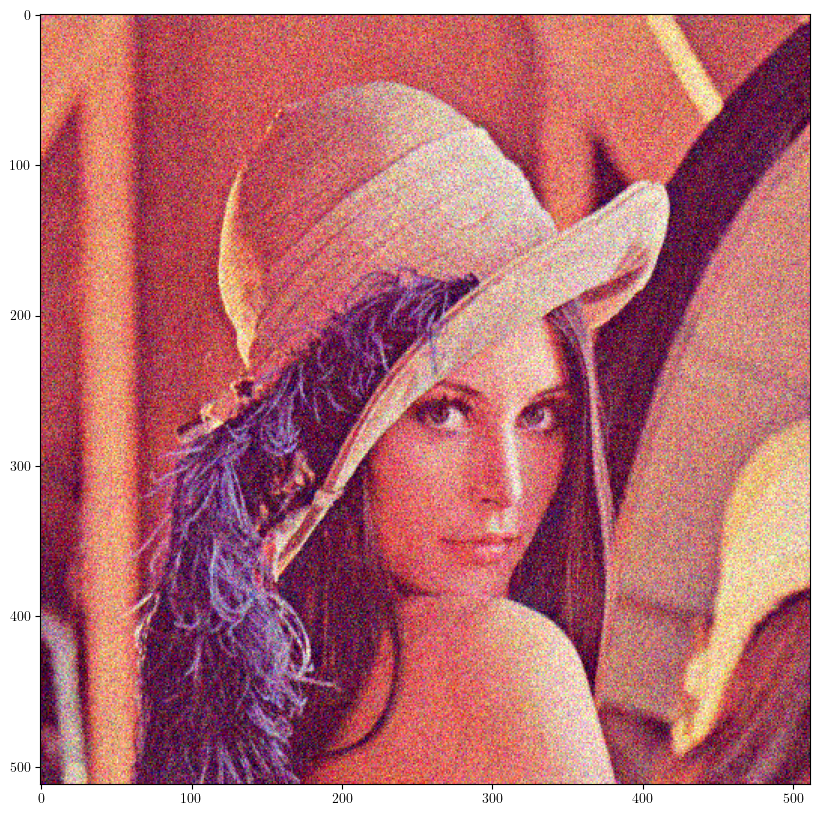

In [14]:
RGB_image.show(noisy_image,"")

In [15]:
def randomize(image, max_distance_x=1, max_distance_y=1):
    height, width, _ = image.shape
    x_coords, y_coords = np.meshgrid(range(width), range(height)) # Create a grid of coordinates
    flattened_x_coords = x_coords.flatten()
    flattened_y_coords = y_coords.flatten()
    displacements_x = np.random.randint(-max_distance_x, max_distance_x + 1, flattened_x_coords.shape)
    displacements_y = np.random.randint(-max_distance_y, max_distance_y + 1, flattened_y_coords.shape)
    randomized_x_coords = flattened_x_coords + displacements_x
    randomized_y_coords = flattened_y_coords + displacements_y
    randomized_x_coords = np.mod(randomized_x_coords, width) # Use periodic extension to handle border pixels
    randomized_y_coords = np.mod(randomized_y_coords, height)
    randomized_image = np.empty_like(image)
    randomized_image[...] = image
    randomized_image[randomized_y_coords,
                     randomized_x_coords, :] = image[flattened_y_coords,
                                                     flattened_x_coords, :]
    return randomized_image

def get_flow_to_project_A_to_B(A, B, l=3, w=15, prev_flow=None, sigma=1.5):
    print(A.shape, B.shape, A.dtype, B.dtype)
    flow = cv2.calcOpticalFlowFarneback(prev=B, next=A, flow=prev_flow,
                                        pyr_scale=0.5, levels=l, winsize=w,
                                        iterations=3, poly_n=5, poly_sigma=sigma,
                                        flags=0)
    #flow[...] = 0.0
    print(np.average(np.abs(flow)), l, w, sigma)
    return flow

def project(image, flow):
    height, width = flow.shape[:2]
    map_x = np.tile(np.arange(width), (height, 1))
    map_y = np.swapaxes(np.tile(np.arange(height), (width, 1)), 0, 1)
    map_xy = (flow + np.dstack((map_x, map_y))).astype('float32')
    warped_image = cv2.remap(image, map_xy, None,
                             #interpolation=cv2.INTER_LANCZOS4, #INTER_LINEAR,
                             interpolation=cv2.INTER_LINEAR,
                             borderMode=cv2.BORDER_REPLICATE)
    return warped_image

def project_A_to_B(A, B, l=3, w=15, prev_flow=None, sigma=1.5):
    A_luma = YUV.from_RGB(A.astype(np.int16))[..., 0]
    B_luma = YUV.from_RGB(B.astype(np.int16))[..., 0]
    flow = get_flow_to_project_A_to_B(A_luma, B_luma, l, w, prev_flow, sigma)
    return project(A, flow)

In [107]:
'''1. denoised_image = 0
2. for i in range(iters):
    1. randomized_noisy_image = randomize(noisy_image)
    2. randomized_and_compensated_noisy_image = project_A_to_B(A=randomized_noisy_image, B=noisy_image)
    3. average_image += (noisy_image + randomized_and_compensated_noisy_image)/2
    4. denoised_image += average_image
3. denoised_image /= iters
'''
'''
iters = 20
denoised_image = np.empty_like(noisy_image, dtype=np.float32)
denoised_image[...] = noisy_image
for i in range(iters):
    randomized_noisy_image = randomize_image(denoised_image)
    OF_compensated_randomized_noisy_image = project_A_to_B(A=randomized_noisy_image, B=denoised_image,
                                                          l=2, w=33, sigma=3.5)
    denoised_image = (denoised_image + OF_compensated_randomized_noisy_image)/2
    plt.imshow(denoised_image.astype(np.uint8))
    plt.show()
'''
acc_image = np.zeros_like(noisy_image, dtype=np.float32)
acc_image[...] = img
iters = 100
for i in range(iters):
    denoised_image = acc_image/(i+1)
    #randomized_noisy_image = randomize(noisy_image, max_distance_x=50, max_distance_y=50).astype(np.float32)
    randomized_noisy_image = randomize(img, max_distance_x=10, max_distance_y=10).astype(np.float32)
    #randomized_and_compensated_noisy_image = project_A_to_B(A=randomized_noisy_image, B=noisy_image, l=5, w=15, sigma=1.5)
    randomized_and_compensated_noisy_image = project_A_to_B(B=randomized_noisy_image, A=denoised_image, l=5, w=15, sigma=1.5)
    #randomized_and_compensated_noisy_image = randomized_noisy_image
    #plt.imshow(randomized_noisy_image.astype(np.uint8))
    #plt.show()
    acc_image += randomized_and_compensated_noisy_image
denoised_image = acc_image/(iters)
print(np.max(denoised_image))

(512, 512) (512, 512) int16 int16
0.78354454 5 15 1.5
(512, 512) (512, 512) int16 int16
0.6891945 5 15 1.5
(512, 512) (512, 512) int16 int16
0.66600835 5 15 1.5
(512, 512) (512, 512) int16 int16
0.6342161 5 15 1.5
(512, 512) (512, 512) int16 int16
0.6086158 5 15 1.5
(512, 512) (512, 512) int16 int16
0.66376555 5 15 1.5
(512, 512) (512, 512) int16 int16
0.58781576 5 15 1.5
(512, 512) (512, 512) int16 int16
0.6197464 5 15 1.5
(512, 512) (512, 512) int16 int16
0.605187 5 15 1.5
(512, 512) (512, 512) int16 int16
0.6324311 5 15 1.5
(512, 512) (512, 512) int16 int16
0.59034675 5 15 1.5
(512, 512) (512, 512) int16 int16
0.58362937 5 15 1.5
(512, 512) (512, 512) int16 int16
0.57215816 5 15 1.5
(512, 512) (512, 512) int16 int16
0.5574842 5 15 1.5
(512, 512) (512, 512) int16 int16
0.5584782 5 15 1.5
(512, 512) (512, 512) int16 int16
0.547625 5 15 1.5
(512, 512) (512, 512) int16 int16
0.60294664 5 15 1.5
(512, 512) (512, 512) int16 int16
0.5706731 5 15 1.5
(512, 512) (512, 512) int16 int16
0.5512

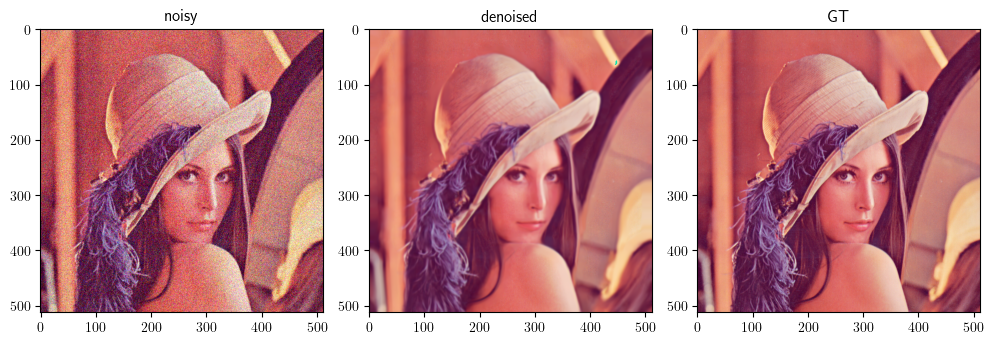

In [110]:
fig, axs = plt.subplots(1, 3, figsize=(10, 8))
axs[0].imshow(noisy_image.astype(np.uint8))
axs[0].set_title("noisy")
axs[1].imshow(denoised_image.astype(np.uint8))
axs[1].set_title("denoised")
axs[2].imshow(img.astype(np.uint8))
axs[2].set_title("GT")
fig.tight_layout()
plt.show()

[image_3.py:87 print_stats() INFO] component=0 max=255 min=0 avg=181.88077926635742
[image_3.py:87 print_stats() INFO] component=1 max=226 min=6 avg=99.77626419067383
[image_3.py:87 print_stats() INFO] component=2 max=210 min=14 avg=106.08443069458008


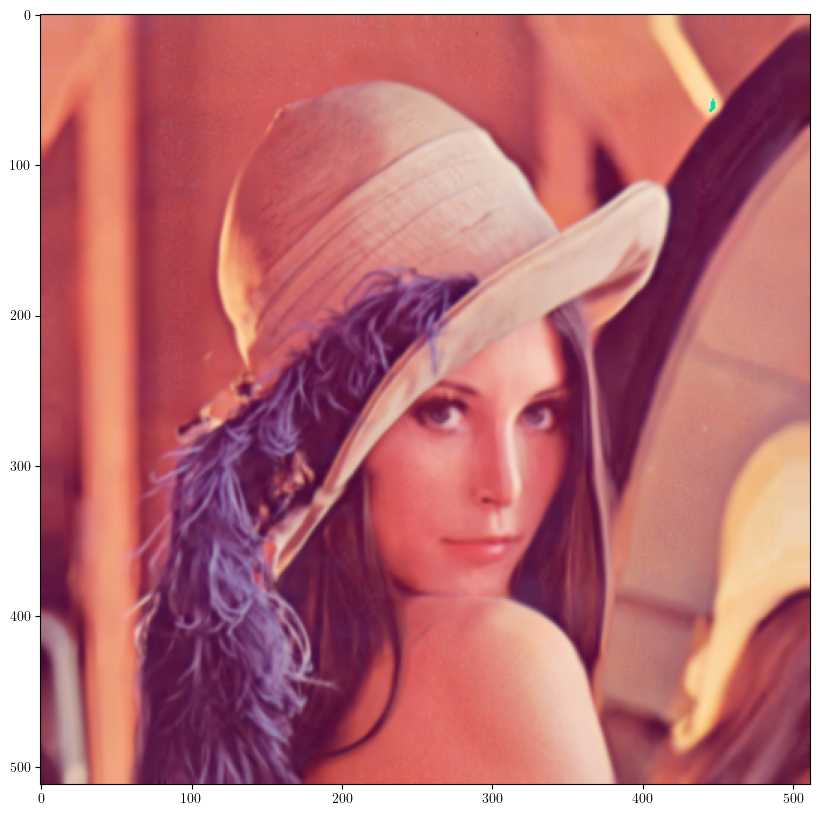

In [111]:
RGB_image.show(denoised_image.astype(np.uint8),"")

In [215]:
acc_image = np.zeros_like(noisy_image, dtype=np.float32)
acc_image[...] = noisy_image
iters = 50
for i in range(iters):
    denoised_image = acc_image/(i+1)
    #randomized_noisy_image = randomize(noisy_image, max_distance_x=50, max_distance_y=50).astype(np.float32)
    randomized_noisy_image = randomize(noisy_image, max_distance_x=9, max_distance_y=9).astype(np.float32)
    #randomized_and_compensated_noisy_image = project_A_to_B(A=randomized_noisy_image, B=noisy_image, l=5, w=15, sigma=1.5)
    randomized_and_compensated_noisy_image = project_A_to_B(B=randomized_noisy_image, A=denoised_image, l=3, w=2, sigma=0.3)
    #randomized_and_compensated_noisy_image = randomized_noisy_image
    #plt.imshow(randomized_noisy_image.astype(np.uint8))
    #plt.show()
    acc_image += randomized_and_compensated_noisy_image
denoised_image = acc_image/(iters + 1)

(512, 512) (512, 512) int16 int16
1.2551885 3 2 0.3
(512, 512) (512, 512) int16 int16
1.2607976 3 2 0.3
(512, 512) (512, 512) int16 int16
1.3619481 3 2 0.3
(512, 512) (512, 512) int16 int16
1.3675073 3 2 0.3
(512, 512) (512, 512) int16 int16
1.3381171 3 2 0.3
(512, 512) (512, 512) int16 int16
1.2632906 3 2 0.3
(512, 512) (512, 512) int16 int16
1.3326187 3 2 0.3
(512, 512) (512, 512) int16 int16
1.2483151 3 2 0.3
(512, 512) (512, 512) int16 int16
1.2755901 3 2 0.3
(512, 512) (512, 512) int16 int16
1.3137449 3 2 0.3
(512, 512) (512, 512) int16 int16
1.2529124 3 2 0.3
(512, 512) (512, 512) int16 int16
1.3125731 3 2 0.3
(512, 512) (512, 512) int16 int16
1.2798129 3 2 0.3
(512, 512) (512, 512) int16 int16
1.2625906 3 2 0.3
(512, 512) (512, 512) int16 int16
1.2767955 3 2 0.3
(512, 512) (512, 512) int16 int16
1.2659078 3 2 0.3
(512, 512) (512, 512) int16 int16
1.2566468 3 2 0.3
(512, 512) (512, 512) int16 int16
1.2836186 3 2 0.3
(512, 512) (512, 512) int16 int16
1.2732234 3 2 0.3
(512, 512) (

[image_3.py:87 print_stats() INFO] component=0 max=244 min=59 avg=177.9232940673828
[image_3.py:87 print_stats() INFO] component=1 max=226 min=11 avg=98.84764862060547
[image_3.py:87 print_stats() INFO] component=2 max=209 min=43 avg=104.62982559204102


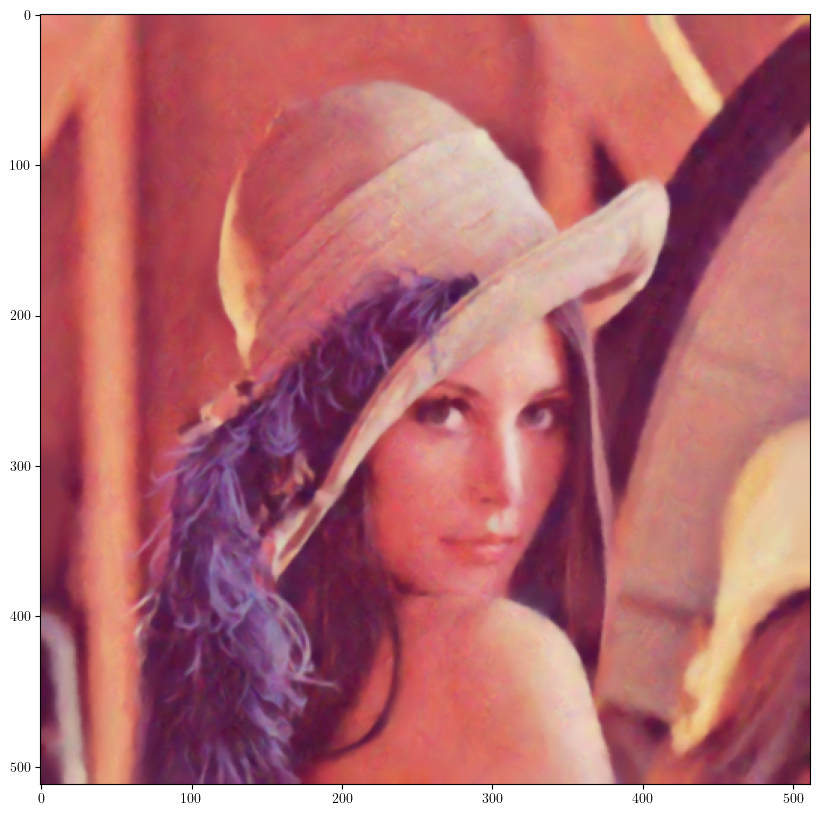

In [216]:
RGB_image.show(denoised_image.astype(np.uint8),"")

In [235]:
acc_image = np.zeros_like(noisy_image, dtype=np.float32)
acc_image[...] = img#noisy_image
iters = 50
for i in range(iters):
    denoised_image = acc_image/(i+1)
    #randomized_noisy_image = randomize(noisy_image, max_distance_x=50, max_distance_y=50).astype(np.float32)
    randomized_noisy_image = randomize(img, max_distance_x=19, max_distance_y=19).astype(np.float32)
    #randomized_and_compensated_noisy_image = project_A_to_B(A=randomized_noisy_image, B=noisy_image, l=5, w=15, sigma=1.5)
    randomized_and_compensated_noisy_image = project_A_to_B(B=randomized_noisy_image, A=denoised_image, l=3, w=2, sigma=0.3)
    #randomized_and_compensated_noisy_image = randomized_noisy_image
    #plt.imshow(randomized_noisy_image.astype(np.uint8))
    #plt.show()
    acc_image += randomized_and_compensated_noisy_image
denoised_image = acc_image/(iters + 1)

(512, 512) (512, 512) int16 int16
3.0371513 3 2 0.3
(512, 512) (512, 512) int16 int16
2.878607 3 2 0.3
(512, 512) (512, 512) int16 int16
2.8720999 3 2 0.3
(512, 512) (512, 512) int16 int16
2.838526 3 2 0.3
(512, 512) (512, 512) int16 int16
2.9391687 3 2 0.3
(512, 512) (512, 512) int16 int16
2.9756415 3 2 0.3
(512, 512) (512, 512) int16 int16
2.7832415 3 2 0.3
(512, 512) (512, 512) int16 int16
2.8421862 3 2 0.3
(512, 512) (512, 512) int16 int16
2.9539864 3 2 0.3
(512, 512) (512, 512) int16 int16
2.7779179 3 2 0.3
(512, 512) (512, 512) int16 int16
2.8951259 3 2 0.3
(512, 512) (512, 512) int16 int16
2.901086 3 2 0.3
(512, 512) (512, 512) int16 int16
2.9626186 3 2 0.3
(512, 512) (512, 512) int16 int16
2.8441045 3 2 0.3
(512, 512) (512, 512) int16 int16
2.8729017 3 2 0.3
(512, 512) (512, 512) int16 int16
2.8161495 3 2 0.3
(512, 512) (512, 512) int16 int16
2.9241655 3 2 0.3
(512, 512) (512, 512) int16 int16
2.8715913 3 2 0.3
(512, 512) (512, 512) int16 int16
2.8889146 3 2 0.3
(512, 512) (512

[image_3.py:87 print_stats() INFO] component=0 max=253 min=74 avg=179.70226287841797
[image_3.py:87 print_stats() INFO] component=1 max=221 min=12 avg=98.86953353881836
[image_3.py:87 print_stats() INFO] component=2 max=204 min=53 avg=105.38211822509766


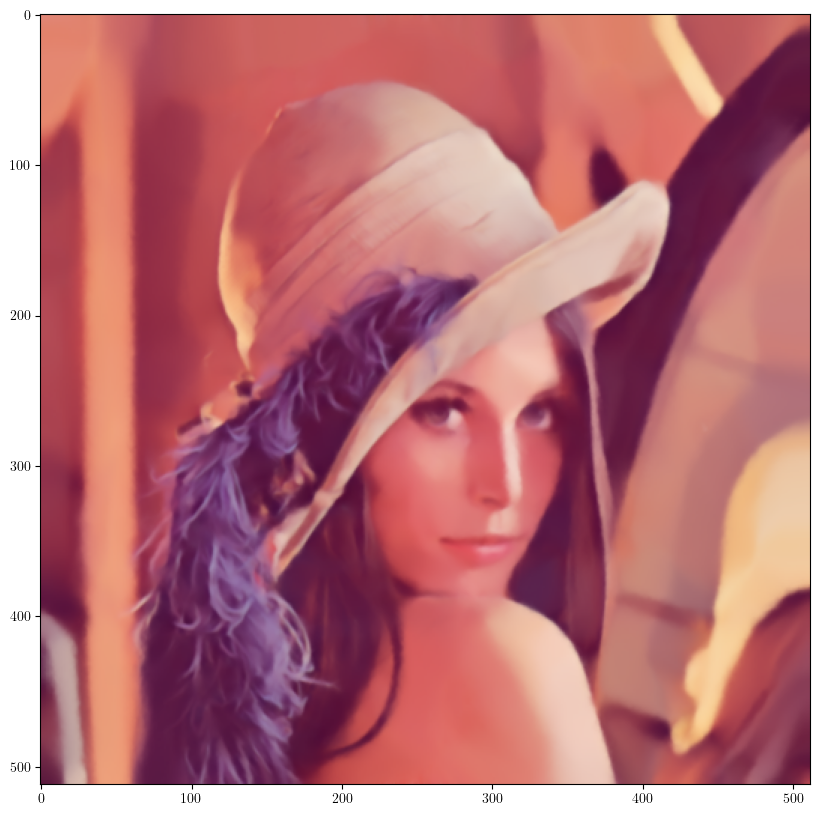

In [236]:
RGB_image.show(denoised_image.astype(np.uint8),"")